In [1]:
cd C:\Users\Lenovo\Documents\data

C:\Users\Lenovo\Documents\data


In [2]:
cd ..

C:\Users\Lenovo\Documents


In [3]:
import torch
import os
import scipy.io as sio
from sklearn.model_selection import train_test_split
import numpy as np

# load data
data_dir_root = os.path.join('./data', 'ThingsEEG-Text')
sbj = 'sub-09'
image_model = 'pytorch/cornet_s'
text_model = 'CLIPText'
roi = '17channels'
brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
image_dir_seen = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
image_dir_unseen = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
text_dir_seen = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)
text_dir_unseen = os.path.join(data_dir_root, 'textual_feature/ThingsTest/text', text_model, sbj)

brain_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
brain_seen = brain_seen[:,:,27:60] # 70ms-400ms
brain_seen = np.reshape(brain_seen, (brain_seen.shape[0], -1))
image_seen = sio.loadmat(os.path.join(image_dir_seen, 'feat_pca_train.mat'))['data'].astype('double')*50.0
text_seen = sio.loadmat(os.path.join(text_dir_seen, 'text_feat_train.mat'))['data'].astype('double')*2.0
label_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
image_seen = image_seen[:,0:100]

brain_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double')*2.0
brain_unseen = brain_unseen[:, :, 27:60]
brain_unseen = np.reshape(brain_unseen, (brain_unseen.shape[0], -1))
image_unseen = sio.loadmat(os.path.join(image_dir_unseen, 'feat_pca_test.mat'))['data'].astype('double')*50.0
text_unseen = sio.loadmat(os.path.join(text_dir_unseen, 'text_feat_test.mat'))['data'].astype('double')*2.0
label_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['class_idx'].T.astype('int')
image_unseen = image_unseen[:, 0:100]

brain_seen = torch.from_numpy(brain_seen)
brain_unseen = torch.from_numpy(brain_unseen)
image_seen = torch.from_numpy(image_seen)
image_unseen = torch.from_numpy(image_unseen)
text_seen = torch.from_numpy(text_seen)
text_unseen = torch.from_numpy(text_unseen)
label_seen = torch.from_numpy(label_seen)
label_unseen = torch.from_numpy(label_unseen)

print('seen_brain_samples=', brain_seen.shape[0], ', seen_brain_features=', brain_seen.shape[1])
print('seen_image_samples=', image_seen.shape[0], ', seen_image_features=', image_seen.shape[1])
print('seen_text_samples=', text_seen.shape[0], ', seen_text_features=', text_seen.shape[1])
print('seen_label=', label_seen.shape)
print('unseen_brain_samples=', brain_unseen.shape[0], ', unseen_brain_features=', brain_unseen.shape[1])
print('unseen_image_samples=', image_unseen.shape[0], ', unseen_image_features=', image_unseen.shape[1])
print('unseen_text_samples=', text_unseen.shape[0], ', unseen_text_features=', text_unseen.shape[1])
print('unseen_label=', label_unseen.shape)

seen_brain_samples= 16540 , seen_brain_features= 561
seen_image_samples= 16540 , seen_image_features= 100
seen_text_samples= 16540 , seen_text_features= 512
seen_label= torch.Size([16540, 1])
unseen_brain_samples= 16000 , unseen_brain_features= 561
unseen_image_samples= 16000 , unseen_image_features= 100
unseen_text_samples= 16000 , unseen_text_features= 512
unseen_label= torch.Size([16000, 1])


In [4]:
label_unseen

tensor([[  1],
        [  2],
        [  3],
        ...,
        [198],
        [199],
        [200]], dtype=torch.int32)

In [5]:
#Make data for training 
import numpy as np
#Use 50 categories
index_seen = np.squeeze(np.where(label_seen < 51, True, False))
index_unseen = np.squeeze(np.where(label_unseen < 51, True, False))

brain_seen = brain_seen[index_seen, :]
image_seen = image_seen[index_seen, :]
text_seen = text_seen[index_seen, :]
label_seen = label_seen[index_seen]
brain_unseen = brain_unseen[index_unseen, :]
image_unseen = image_unseen[index_unseen, :]
text_unseen = text_unseen[index_unseen, :]
label_unseen = label_unseen[index_unseen]

#The ThingsEEG-Text dataset is mainly designed and used for Zero-Shot type research work, because the independence of its training set and test set
#in categories is very suitable for this task. If it needs to be used for other types of tasks
#(such as general classification or cross-modal learning),
#the data may need to be repartitioned. Therefore, we repartition the dataset to make it better for our task
#Define the number of classes and the number of samples per class
num_classes = 20
samples_per_class = 10
train_ratio = 0.50 
#For each class, take the first 5 images as training and the last 5 images as testing
new_train_brain = []
new_train_image = []
new_train_text = []
new_train_label = []

new_test_brain = []
new_test_image = []
new_test_text = []
new_test_label = []

for i in range(num_classes):
    start_idx = i * samples_per_class   #The starting index of the current class
    end_idx = start_idx + samples_per_class   #The end index of the current class
    
    #Get the data of the current class
    class_data_brain = brain_seen[start_idx:end_idx, :]
    class_data_image = image_seen[start_idx:end_idx, :]
    class_data_text = text_seen[start_idx:end_idx, :]
    class_data_label = label_seen[start_idx:end_idx, :]
    
    # Determine train and test split
    num_train_samples = int(samples_per_class * train_ratio)
    num_test_samples = samples_per_class - num_train_samples
    
    # Split into training and testing sets
    new_train_brain.append(class_data_brain[:num_train_samples])
    new_test_brain.append(class_data_brain[num_train_samples:])
    
    new_train_image.append(class_data_image[:num_train_samples])
    new_test_image.append(class_data_image[num_train_samples:])
    
    new_train_text.append(class_data_text[:num_train_samples])
    new_test_text.append(class_data_text[num_train_samples:])
    
    new_train_label.append(class_data_label[:num_train_samples])
    new_test_label.append(class_data_label[num_train_samples:])


train_brain = torch.vstack(new_train_brain)
train_image = torch.vstack(new_train_image)
train_text = torch.vstack(new_train_text)
train_label = torch.vstack(new_train_label)
test_brain = torch.vstack(new_test_brain)
test_image = torch.vstack(new_test_image)
test_text = torch.vstack(new_test_text)
test_label = torch.vstack(new_test_label)

# Check for NaN values in each tensor
print("NaN values in train_brain:", torch.sum(torch.isnan(train_brain)).item())
print("NaN values in train_image:", torch.sum(torch.isnan(train_image)).item())
print("NaN values in train_text:", torch.sum(torch.isnan(train_text)).item())
print("NaN values in train_label:", torch.sum(torch.isnan(train_label)).item())

print(train_brain.shape)
print(train_image.shape)
print(train_text.shape)
print(train_label.shape)
print(test_brain.shape)
print(test_image.shape)
print(test_text.shape)
print(test_label.shape)

NaN values in train_brain: 0
NaN values in train_image: 0
NaN values in train_text: 0
NaN values in train_label: 0
torch.Size([100, 561])
torch.Size([100, 100])
torch.Size([100, 512])
torch.Size([100, 1])
torch.Size([100, 561])
torch.Size([100, 100])
torch.Size([100, 512])
torch.Size([100, 1])


In [6]:
#Converting tensor to numpy array 
import torch
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

train_brain_np = train_brain.numpy()
train_image_np = train_image.numpy()
train_text_np = train_text.numpy()
train_label_np = train_label.numpy().ravel()

test_brain_np = test_brain.numpy()
test_image_np = test_image.numpy()
test_text_np = test_text.numpy()
test_label_np = test_label.numpy().ravel()

# Check for NaN values in each array
print("NaN values in train_brain_np:", np.sum(np.isnan(train_brain_np)))
print("NaN values in train_image_np:", np.sum(np.isnan(train_image_np)))
print("NaN values in train_text_np:", np.sum(np.isnan(train_text_np)))
print("NaN values in train_label_np:", np.sum(np.isnan(train_label_np)))

#Check class imbalance 
unique_classes, class_counts = np.unique(train_label_np, return_counts=True)
print("Class distribution in the training set:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")


NaN values in train_brain_np: 0
NaN values in train_image_np: 0
NaN values in train_text_np: 0
NaN values in train_label_np: 0
Class distribution in the training set:
Class 1: 5 samples
Class 2: 5 samples
Class 3: 5 samples
Class 4: 5 samples
Class 5: 5 samples
Class 6: 5 samples
Class 7: 5 samples
Class 8: 5 samples
Class 9: 5 samples
Class 10: 5 samples
Class 11: 5 samples
Class 12: 5 samples
Class 13: 5 samples
Class 14: 5 samples
Class 15: 5 samples
Class 16: 5 samples
Class 17: 5 samples
Class 18: 5 samples
Class 19: 5 samples
Class 20: 5 samples


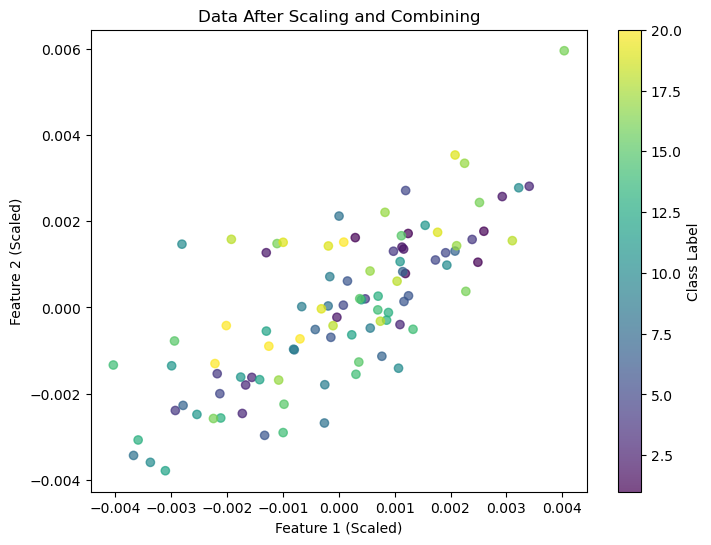

Original shape: (100, 1173), After interactions: (100, 688551)
Original shape: (100, 1173), After interactions: (100, 688551)


In [7]:
#Feature Scaling 
from sklearn.preprocessing import StandardScaler
import numpy as np

#Scale the train data 
scaler_train_brain = StandardScaler()
scaler_train_text = StandardScaler()
scaler_train_image = StandardScaler() 

train_brain_normalized = scaler_train_brain.fit_transform(train_brain_np)
train_text_normalized = scaler_train_text.fit_transform(train_text_np)
train_image_normalized = scaler_train_image.fit_transform(train_image_np)

#Scale the test data 
scaler_test_brain = StandardScaler()
scaler_test_text = StandardScaler() 
scaler_test_image = StandardScaler()

test_brain_normalized = scaler_test_brain.fit_transform(test_brain_np)
test_text_normalized = scaler_test_text.fit_transform(test_text_np)
test_image_normalized = scaler_test_image.fit_transform(test_image_np)

#Calculate scaling factors for equal contribution 
train_brain_weight = 1 / train_brain_normalized.shape[1]
train_text_weight = 1 / train_text_normalized.shape[1]
train_image_weight = 1 / train_image_normalized.shape[1]

test_brain_weight = 1 / test_brain_normalized.shape[1]
test_text_weight = 1 / test_text_normalized.shape[1]
test_image_weight = 1 / test_image_normalized.shape[1]

# Apply weights
train_balanced_brain = train_brain_normalized * train_brain_weight
train_balanced_text = train_text_normalized * train_text_weight 
train_balanced_image = train_image_normalized * train_image_weight
test_balanced_brain = test_brain_normalized * test_brain_weight
test_balanced_text = test_text_normalized * test_text_weight 
test_balanced_image = test_image_normalized * test_image_weight

#Feature combination 
train_features_multiple = np.concatenate([train_balanced_brain, train_balanced_text, train_balanced_image], axis =1)
test_features_multiple = np.concatenate([test_balanced_brain, test_balanced_text, test_balanced_image], axis =1)

from sklearn.preprocessing import PolynomialFeatures
# Generate polynomial features, including interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_features_multiple_interactions = poly.fit_transform(train_features_multiple)
test_features_multiple_interactions = poly.fit_transform(test_features_multiple)

#Visualising after standardisation and combining 
#Scatter plot of scaled data
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(train_features_multiple[:, 0], train_features_multiple[:, 1], c=train_label_np, cmap='viridis', alpha=0.7)
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.title("Data After Scaling and Combining")
plt.colorbar(label="Class Label")
plt.show()

#Visualising before and after feature interactions 
print(f"Original shape: {train_features_multiple.shape}, After interactions: {train_features_multiple_interactions.shape}")
print(f"Original shape: {test_features_multiple.shape}, After interactions: {test_features_multiple_interactions.shape}")

In [8]:
!pip install umap-learn

Number of components for 95% variance: 68


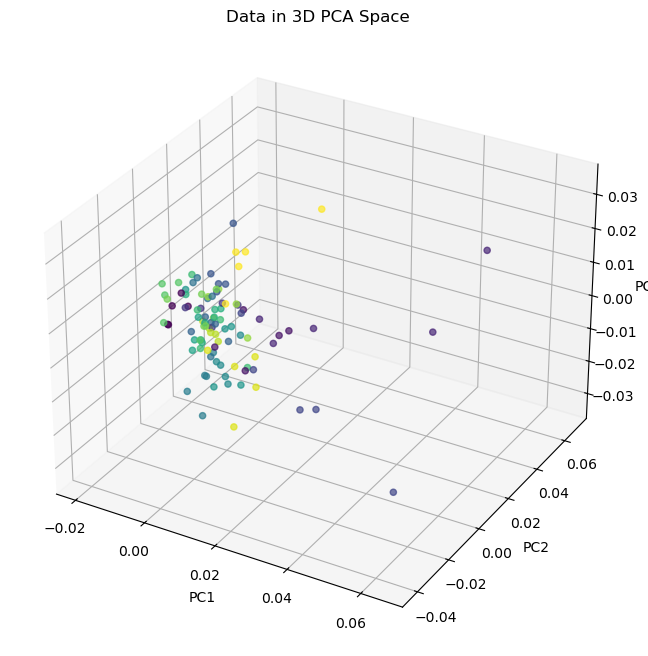

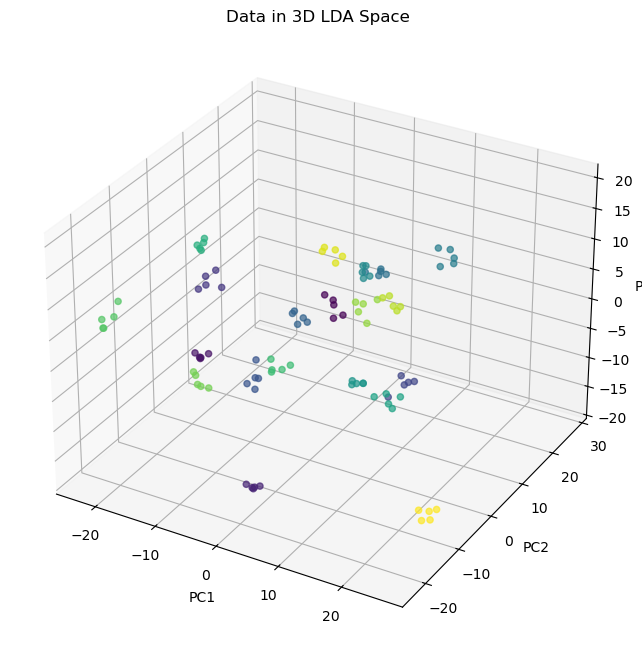

C:\Users\Lenovo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Lenovo\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

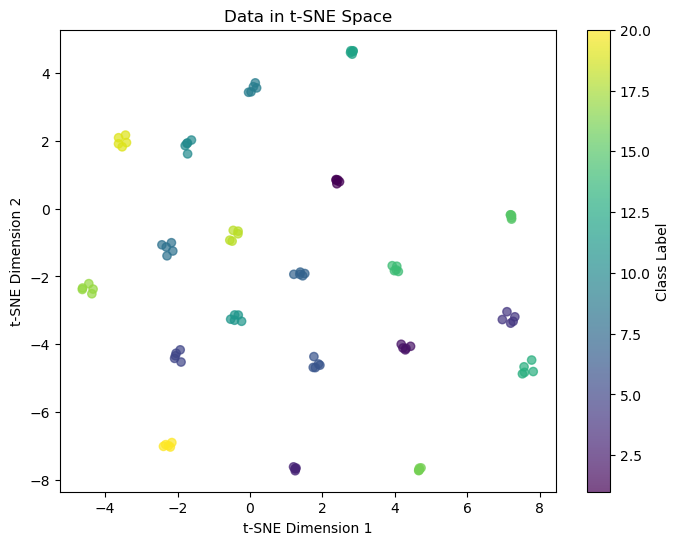

C:\Users\Lenovo\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


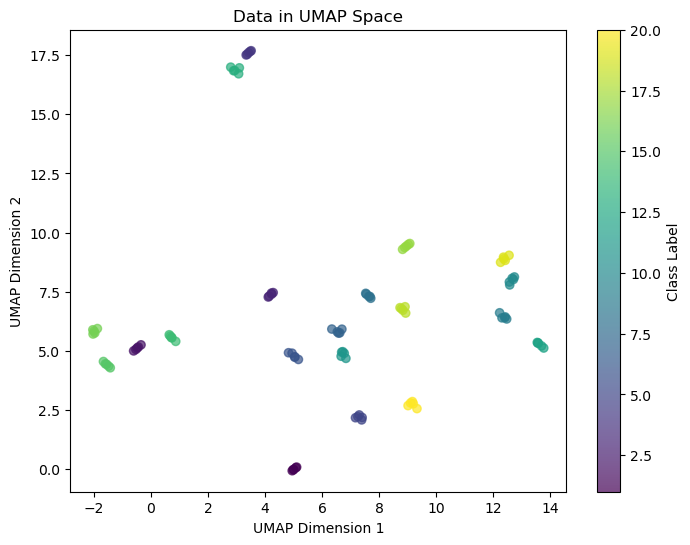

In [9]:
#PCA 
from sklearn.decomposition import PCA, KernelPCA

#Using standard PCA to determine the number of components for 95% variance
pca = PCA(n_components=0.95)
pca.fit(train_features_multiple_interactions)
num_components = len(pca.explained_variance_ratio_)  

print(f"Number of components for 95% variance: {num_components}")

#Use Kernel PCA with the determined number of components
kpca = KernelPCA(n_components=num_components, kernel='rbf', gamma=0.1)  
train_features_kpca = kpca.fit_transform(train_features_multiple_interactions)
test_features_kpca = kpca.transform(test_features_multiple_interactions)

#LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Initialize LDA
lda = LinearDiscriminantAnalysis()
train_features_lda = lda.fit_transform(train_features_kpca, train_label_np) #train_features_pca -> data -> cleaned_data , train_label_np -> true_labels -> cleaned_labels 
test_features_lda = lda.transform(test_features_kpca) #same applied for test

#import umap.umap_ as umap
#Apply UMAP on PCA-reduced data
#umap_reducer = umap.UMAP(n_components=2, random_state=42)
#train_features_umap = umap_reducer.fit_transform(train_features_lda)
#test_features_umap = umap_reducer.transform(test_features_lda)

# Visualize the data after PCA
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_features_kpca[:, 0], train_features_kpca[:, 1], train_features_kpca[:, 2], c=train_label_np, cmap='viridis', alpha=0.7)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Data in 3D PCA Space")
plt.show()

# Visualize the data after LDA
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_features_lda[:, 0], train_features_lda[:, 1], train_features_lda[:, 2], c=train_label_np, cmap='viridis', alpha=0.7)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Data in 3D LDA Space")
plt.show()

# t-SNE to capture nonlinear patterns 
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features_lda) 

plt.figure(figsize=(8, 6))
plt.scatter(train_features_tsne[:, 0], train_features_tsne[:, 1], c=train_label_np, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Data in t-SNE Space")
plt.colorbar(label="Class Label")
plt.show()

# UMAP, similar to t-SNE but more computational efficient 
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
train_features_umap_map = reducer.fit_transform(train_features_lda)  

plt.figure(figsize=(8, 6))
plt.scatter(train_features_umap_map[:, 0], train_features_umap_map[:, 1], c=train_label_np, cmap='viridis', alpha=0.7)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Data in UMAP Space")
plt.colorbar(label="Class Label")
plt.show()

Classification Report (K-Means Clusters vs True Labels):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       5.0
           2       0.00      0.00      0.00       5.0
           3       0.00      0.00      0.00       5.0
           4       0.00      0.00      0.00       5.0
           5       0.00      0.00      0.00       5.0
           6       0.00      0.00      0.00       5.0
           7       0.00      0.00      0.00       5.0
           8       0.00      0.00      0.00       5.0
           9       0.00      0.00      0.00       5.0
          10       0.00      0.00      0.00       5.0
          11       0.00      0.00      0.00       5.0
          12       0.00      0.00      0.00       5.0
          13       0.00      0.00      0.00       5.0
          14       0.00      0.00      0.00       5.0
          15       0.00      0.00      0.00       5.0
          16       0.00 

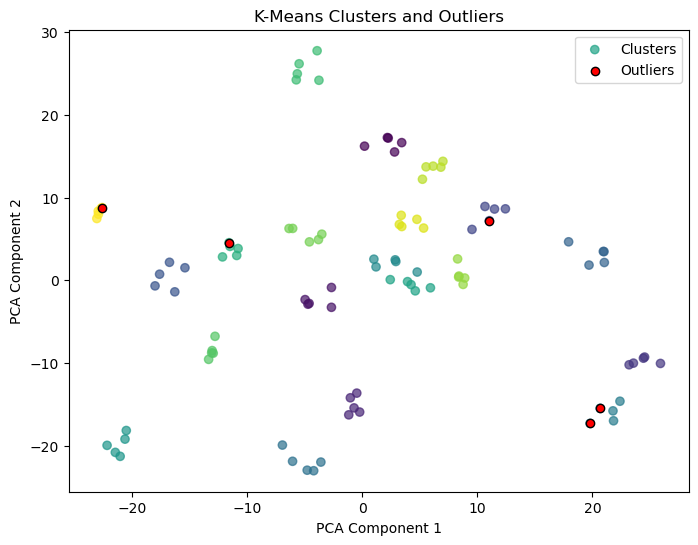

Original data shape: (100, 19)
Original labels shape: (100,)
Cleaned data shape: (95, 19)
Cleaned labels shape: (95,)


In [10]:
###Errors/Warnings 
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
from sklearn.exceptions import UndefinedMetricWarning  # Import the warning explicitly
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
###

# Use clustering techniques to identify potential outliers
# Apply k-Means to identify noise 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import numpy as np

data = train_features_lda  
true_labels = train_label_np  

# Number of clusters = number of classes
n_clusters = len(np.unique(true_labels))
# Fit K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data)

# Get cluster assignments
cluster_labels = kmeans.labels_

# Compare K-Means clusters to true labels
print("Classification Report (K-Means Clusters vs True Labels):")
print(classification_report(true_labels, cluster_labels))

# Find mismatched points
mismatches = np.where(cluster_labels != true_labels)[0]
print(f"Number of mismatched points: {len(mismatches)}")

# Compute distances of each point to its cluster center
distances = kmeans.transform(data)  # Distance to each cluster center
assigned_cluster_distances = distances[np.arange(len(data)), cluster_labels]

# Identify outliers based on a threshold 
threshold = np.percentile(assigned_cluster_distances, 95)
outliers = np.where(assigned_cluster_distances > threshold)[0]

print(f"Number of potential outliers: {len(outliers)}")

import matplotlib.pyplot as plt

# Scatter plot of data with K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, label='Clusters')
plt.scatter(data[outliers, 0], data[outliers, 1], c='red', label='Outliers', edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters and Outliers")
plt.legend()
plt.show()

cleaned_data = np.delete(data, outliers, axis=0)
cleaned_labels = np.delete(true_labels, outliers, axis=0)

# Double-check the shapes to ensure alignment
print(f"Original data shape: {data.shape}")
print(f"Original labels shape: {true_labels.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")
print(f"Cleaned labels shape: {cleaned_labels.shape}")

# Assert that data and labels are still aligned
assert cleaned_data.shape[0] == cleaned_labels.shape[0], "Mismatch between cleaned data and labels!"

Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           1       0.83      1.00      0.91         5
           2       1.00      0.60      0.75         5
           3       1.00      0.60      0.75         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.71      1.00      0.83         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       0.62      1.00      0.77         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00      0.60      0.7

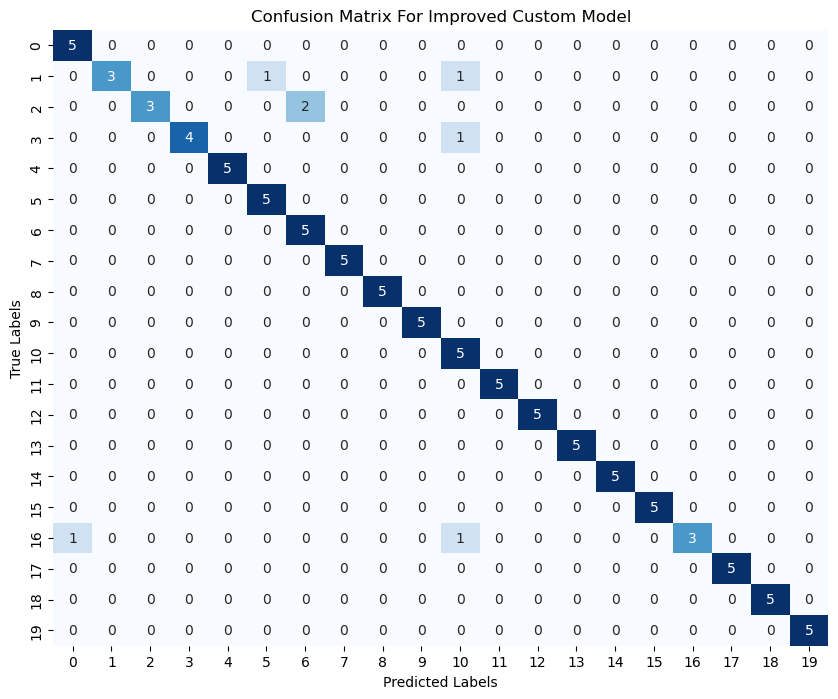

C: 0.1, gamma: 0.001, accuracy: 0.9074
C: 0.1, gamma: 0.01, accuracy: 0.9595
C: 0.1, gamma: 0.1, accuracy: 1.0000
C: 0.1, gamma: 1, accuracy: 1.0000
C: 0.1, gamma: 10, accuracy: 1.0000
C: 1, gamma: 0.001, accuracy: 0.9595
C: 1, gamma: 0.01, accuracy: 0.9775
C: 1, gamma: 0.1, accuracy: 1.0000
C: 1, gamma: 1, accuracy: 1.0000
C: 1, gamma: 10, accuracy: 0.9900
C: 10, gamma: 0.001, accuracy: 0.9800
C: 10, gamma: 0.01, accuracy: 0.9800
C: 10, gamma: 0.1, accuracy: 0.9900
C: 10, gamma: 1, accuracy: 1.0000
C: 10, gamma: 10, accuracy: 1.0000
C: 100, gamma: 0.001, accuracy: 0.9670
C: 100, gamma: 0.01, accuracy: 0.9595
C: 100, gamma: 0.1, accuracy: 1.0000
C: 100, gamma: 1, accuracy: 1.0000
C: 100, gamma: 10, accuracy: 1.0000
C: 1000, gamma: 0.001, accuracy: 0.9695
C: 1000, gamma: 0.01, accuracy: 1.0000
C: 1000, gamma: 0.1, accuracy: 1.0000
C: 1000, gamma: 1, accuracy: 1.0000
C: 1000, gamma: 10, accuracy: 1.0000
Best Parameters: {'C': 0.1, 'gamma': 0.1}
Best Cross-Validation Accuracy: 1.0000


In [11]:
import numpy as np
from typing import Dict, Any, Optional
import time

class CustomSVM:
    def __init__(self, C: float = 10.0, gamma: str = 'auto', max_iter: int = 1000, 
                 tol: float = 1e-3, class_weight: Optional[str] = None):
        self.C = C
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.class_weight = class_weight
        self.classifiers: Dict[Any, Dict] = {}
        self.classes = None
        self.n_features = None
        self.bias = 0.0
        self.kernel_cache = {}  # Cache for kernel computations

    def _compute_gamma(self, X: np.ndarray) -> float:
        """Compute the gamma parameter if auto"""
        if self.gamma == 'auto':
            return 1.0 / (X.shape[1] * X.var()) if X.var() != 0 else 1.0
        return float(self.gamma)

    def _compute_class_weights(self, y: np.ndarray) -> Dict:
        """Compute class weights if needed"""
        if self.class_weight == 'balanced':
            classes = np.unique(y)
            weights = {}
            n_samples = len(y)
            for c in classes:
                weights[c] = n_samples / (len(classes) * np.sum(y == c))
            return weights
        return {c: 1.0 for c in np.unique(y)}

    def rbf_kernel(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """Compute the RBF kernel for two vectors."""
        diff = x1 - x2
        return np.exp(-self.gamma * np.dot(diff, diff))

    def rbf_kernel_matrix(self, X1: np.ndarray, X2: np.ndarray) -> np.ndarray:
        """Compute RBF kernel matrix using efficient vectorization"""
        # Compute squared Euclidean distances efficiently
        X1_norm = np.sum(X1 ** 2, axis=1)
        X2_norm = np.sum(X2 ** 2, axis=1)
        distances = X1_norm[:, np.newaxis] + X2_norm - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * np.maximum(distances, 0))

    def _train_one_vs_all(self, X: np.ndarray, y: np.ndarray, 
                         positive_class: Any, class_weights: Dict) -> Dict:
        """Train a binary SVM for one class vs all others"""
        n_samples = len(X)
        alpha = np.zeros(n_samples)
        self.bias = 0.0
        
        # Convert to binary problem
        binary_y = np.where(y == positive_class, 1, -1)
        
        # Compute kernel matrix once
        K = self.rbf_kernel_matrix(X, X)
        
        # Compute sample weights
        sample_weights = np.array([class_weights[y[i]] for i in range(n_samples)])
        
        # Improved SMO algorithm
        changed = True
        iteration = 0
        
        while changed and iteration < self.max_iter:
            changed = False
            iteration += 1
            
            # Compute errors for all points
            errors = np.dot(K, (alpha * binary_y)) + self.bias - binary_y
            
            # First pass: examine non-bound examples
            for i in range(n_samples):
                if 0 < alpha[i] < self.C * sample_weights[i]:
                    if self._optimize_pair(i, alpha, binary_y, K, sample_weights, errors):
                        changed = True
                        errors = np.dot(K, (alpha * binary_y)) + self.bias - binary_y
            
            # Second pass: examine all examples
            if not changed:
                for i in range(n_samples):
                    if self._optimize_pair(i, alpha, binary_y, K, sample_weights, errors):
                        changed = True
                        errors = np.dot(K, (alpha * binary_y)) + self.bias - binary_y
        
        # Save support vectors
        support_mask = alpha > 1e-5
        return {
            'alpha': alpha[support_mask],
            'support_vectors': X[support_mask],
            'support_vector_labels': binary_y[support_mask],
            'bias': self.bias
        }

    def _optimize_pair(self, i: int, alpha: np.ndarray, y: np.ndarray, 
                      K: np.ndarray, sample_weights: np.ndarray, 
                      errors: np.ndarray) -> bool:
        """Optimize a pair of examples"""
        Ei = errors[i]
        yi = y[i]
        
        if (yi * Ei < -self.tol and alpha[i] < self.C * sample_weights[i]) or \
           (yi * Ei > self.tol and alpha[i] > 0):
            
            # Select second example
            if len(alpha[alpha > 0]) > 1:
                if Ei > 0:
                    j = np.argmin(errors)
                else:
                    j = np.argmax(errors)
                
                if self._take_step(i, j, alpha, y, K, sample_weights, errors):
                    return True
            
            # Try all non-zero and non-C alpha
            non_bound = np.where((alpha > 0) & (alpha < self.C * sample_weights))[0]
            np.random.shuffle(non_bound)
            for j in non_bound:
                if j != i and self._take_step(i, j, alpha, y, K, sample_weights, errors):
                    return True
            
            # Try all examples
            all_indices = np.random.permutation(len(y))
            for j in all_indices:
                if j != i and self._take_step(i, j, alpha, y, K, sample_weights, errors):
                    return True
        
        return False

    def _take_step(self, i: int, j: int, alpha: np.ndarray, y: np.ndarray, 
                  K: np.ndarray, sample_weights: np.ndarray, 
                  errors: np.ndarray) -> bool:
        """Attempt to optimize two examples"""
        if i == j:
            return False
        
        alpha_i_old = alpha[i]
        alpha_j_old = alpha[j]
        yi = y[i]
        yj = y[j]
        
        if yi != yj:
            L = max(0, alpha_j_old - alpha_i_old)
            H = min(self.C * sample_weights[j], 
                   self.C * sample_weights[j] + alpha_j_old - alpha_i_old)
        else:
            L = max(0, alpha_i_old + alpha_j_old - self.C * sample_weights[i])
            H = min(self.C * sample_weights[j], alpha_i_old + alpha_j_old)
        
        if L == H:
            return False
        
        eta = 2 * K[i,j] - K[i,i] - K[j,j]
        if eta >= 0:
            return False
        
        alpha[j] = alpha_j_old - yj * (errors[i] - errors[j]) / eta
        alpha[j] = min(H, max(L, alpha[j]))
        
        if abs(alpha[j] - alpha_j_old) < 1e-5:
            return False
        
        alpha[i] = alpha_i_old + yi * yj * (alpha_j_old - alpha[j])
        
        # Update bias
        b1 = self.bias - errors[i] - yi * (alpha[i] - alpha_i_old) * K[i,i] \
             - yj * (alpha[j] - alpha_j_old) * K[i,j]
        b2 = self.bias - errors[j] - yi * (alpha[i] - alpha_i_old) * K[i,j] \
             - yj * (alpha[j] - alpha_j_old) * K[j,j]
        
        if 0 < alpha[i] < self.C * sample_weights[i]:
            self.bias = b1
        elif 0 < alpha[j] < self.C * sample_weights[j]:
            self.bias = b2
        else:
            self.bias = (b1 + b2) / 2
        
        return True

    def fit(self, X: np.ndarray, y: np.ndarray):
        """Train one SVM for each class"""
        self.n_features = X.shape[1]
        self.gamma = self._compute_gamma(X)
        self.classes = np.unique(y)
        class_weights = self._compute_class_weights(y)
        
        # Scale features to [0, 1] range
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8)
        
        for class_label in self.classes:
            self.classifiers[class_label] = self._train_one_vs_all(X, y, class_label, class_weights)


    def _predict_one(self, x, classifier):
        """Get prediction score for one classifier"""
        decision = 0
        for alpha, sv_y, sv_x in zip(classifier['alpha'], 
                                   classifier['support_vector_labels'],
                                   classifier['support_vectors']):
            decision += alpha * sv_y * self.rbf_kernel(x, sv_x)
        return decision + classifier['bias']

    def predict(self, X):
        """Predict class labels for samples in X"""
        # cale features using same scaling as in fit
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-8)
        
        n_samples = len(X)
        predictions = np.zeros((n_samples, len(self.classes)))
        
        # Get scores from all classifiers
        for i, class_label in enumerate(self.classes):
            classifier = self.classifiers[class_label]
            for j, x in enumerate(X):
                predictions[j, i] = self._predict_one(x, classifier)
        
        # Apply softmax to get probabilities
        exp_preds = np.exp(predictions - np.max(predictions, axis=1, keepdims=True))
        probabilities = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)
        
        # Return class with highest probability
        return self.classes[np.argmax(probabilities, axis=1)]

def stratified_k_fold_split(X, y, k):
    """Manually split the dataset into stratified k folds."""
    # Add the stratified_k_fold_split function here
    classes, class_indices = np.unique(y, return_inverse=True)
    class_counts = np.bincount(class_indices)
    class_folds = {c: [] for c in classes}

    for c in classes:
        class_samples = np.where(y == c)[0]
        np.random.shuffle(class_samples)
        class_folds[c] = np.array_split(class_samples, k)

    folds = []
    for i in range(k):
        test_indices = []
        for c in classes:
            test_indices.extend(class_folds[c][i])
        test_indices = np.array(test_indices)
        train_indices = np.setdiff1d(np.arange(len(y)), test_indices)
        folds.append((train_indices, test_indices))
    return folds

def stratified_cross_validate(X, y, svm_class, param_grid, k=5):
    """Manually perform stratified cross-validation."""
    # Add the stratified_cross_validate function here
    folds = stratified_k_fold_split(X, y, k)
    best_params = None
    best_score = 0

    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            fold_scores = []

            for train_idx, test_idx in folds:
                X_train, y_train = X[train_idx], y[train_idx]
                X_test, y_test = X[test_idx], y[test_idx]

                svm = svm_class(C=C, gamma=gamma, max_iter=1000, class_weight='balanced')
                svm.fit(X_train, y_train)
                y_pred = svm.predict(X_test)

                acc = np.mean(y_pred == y_test)
                fold_scores.append(acc)

            mean_score = np.mean(fold_scores)
            print(f"C: {C}, gamma: {gamma}, accuracy: {mean_score:.4f}")

            if mean_score > best_score:
                best_score = mean_score
                best_params = {'C': C, 'gamma': gamma}

    return best_params, best_score

def accuracy_score(y_true, y_pred):
    """Compute accuracy score"""
    return np.mean(y_true == y_pred)

def classification_report(y_true, y_pred):
    """Generate a classification report"""
    classes = np.unique(y_true)
    report = ""
    
    # Compute macro averages
    macro_precision = 0
    macro_recall = 0
    macro_f1 = 0
    n_classes = len(classes)
    
    for c in classes:
        true_pos = np.sum((y_true == c) & (y_pred == c))
        false_pos = np.sum((y_true != c) & (y_pred == c))
        false_neg = np.sum((y_true == c) & (y_pred != c))
        
        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        macro_precision += precision
        macro_recall += recall
        macro_f1 += f1
        
        report += f"Class {c}:\n"
        report += f"Precision: {precision:.3f}\n"
        report += f"Recall: {recall:.3f}\n"
        report += f"F1-score: {f1:.3f}\n\n"
    
    # Add macro averages to report
    report += "Macro Averages:\n"
    report += f"Precision: {macro_precision/n_classes:.3f}\n"
    report += f"Recall: {macro_recall/n_classes:.3f}\n"
    report += f"F1-score: {macro_f1/n_classes:.3f}\n"
    
    return report

# Initializing the CustomSVM
class_weights = {0: 1.0, 1: 2.0}  # Heavier penalty for minority class
svm = CustomSVM(C=0.1, gamma=1, max_iter=2000, class_weight='balanced')

# Train
start_train_time = time.time()
svm.fit(cleaned_data, cleaned_labels)
end_train_time = time.time()

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predict
start_test_time = time.time()
predictions = svm.predict(test_features_lda)  
end_test_time = time.time()

# Evaluate
accuracy = accuracy_score(test_label_np, predictions)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(test_label_np, predictions))
print(f"Training time: {end_train_time - start_train_time:.2f} seconds")
print(f"Testing time: {end_test_time - start_test_time:.2f} seconds")

# Generate and plot the confusion matrix
confusion_mtx = confusion_matrix(test_label_np, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix For Improved Custom Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


#param_grid = {
#    'C': [0.1, 1, 10, 100, 1000],
#    'gamma': [0.001, 0.01, 0.1, 1, 10]
#}
#best_params, best_score = stratified_cross_validate(cleaned_data, cleaned_labels, CustomSVM, param_grid, k=5)
#print(f"Best Parameters: {best_params}")
#print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

import matplotlib.pyplot as plt

def plot_class_distribution(X, y, title="Class Distribution"):
    """Plot class distribution."""
    classes = np.unique(y)
    for cls in classes:
        plt.scatter(X[y == cls, 0], X[y == cls, 1], label=f"Class {cls}", alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()
